In [1]:
from esda.moran import Moran
import geopandas as gpd
import json
import numpy as np
import pandas as pd
from libpysal.weights import DistanceBand, KNN
from matplotlib import colors
import matplotlib.pyplot as plt
from splot.esda import plot_moran
import spreg

from statshelper import q_q_plot
plt.style.use('dark_background')

In [2]:
df = pd.read_csv("./data/processed/Cleaned_Chicago_Sales.csv")
df.head()

,Unnamed: 0,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
0,2,16094150130000,211,13,-0.297580,77,3.0,6.0,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5,4252000820000,204,100,2.868180,25,5.0,0.0,2.0,4.0,...,0,0,0,0,0,0,1,0,0,0
2,8,14322110150000,208,12,-0.596010,74,3.0,0.0,2.0,6.0,...,0,0,0,0,0,0,1,0,0,0
3,9,27021200080000,204,34,1.698873,28,1.0,0.0,3.0,1.0,...,1,0,0,0,0,0,0,1,0,0
4,11,13121080620000,204,42,0.515768,71,1.0,0.0,2.0,1.0,...,1,0,0,0,0,0,1,0,0,0


In [3]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:26916")

In [4]:
i_vars = [
    'Age',
    'Bedrooms',  
    'Building Square Feet', 
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Full Baths',
    'Garage 1 Area',
    'Garage 2 Area', 
    'Half Baths', 
    'Land Square Feet',
    'Rooms',
    'Sale Quarter'
    ]
dep_var = ['Sale Price']
other_to_keep = ["PIN", "Neighborhood Code", "Town Code", "geometry"]
my_rows = i_vars+dep_var+other_to_keep
gdf = gdf[my_rows]
gdf = gdf.sample(frac=.025)
print("Dataframe has {} rows and {} columns".format(len(gdf), len(list(gdf.columns))))
X = gdf[i_vars].values
y = gdf[dep_var].values.ravel()
gdf.head()

Dataframe has 8107 rows and 18 columns


,Age,Bedrooms,Building Square Feet,Estimate (Building),Estimate (Land),Fireplaces,Full Baths,Garage 1 Area,Garage 2 Area,Half Baths,Land Square Feet,Rooms,Sale Quarter,Sale Price,PIN,Neighborhood Code,Town Code,geometry
243081,-0.134968,0.550809,0.954823,1.411848,1.831167,1.422378,0.635637,0.550000,-0.041762,1.066654,1.101580,0.562606,0.894856,1.114208,4014010490000,10,23,POINT (436037.430 4665911.265)
226558,-0.421567,-0.292681,-0.591661,-0.395514,-0.219269,-0.599533,-0.891279,0.550000,-0.041762,-0.848209,-0.466636,-0.268846,-1.233509,-0.444546,19261070160000,30,72,POINT (440692.285 4623700.006)
104033,0.024254,-0.292681,0.044184,0.277911,-0.194255,1.422378,-0.891279,0.550000,-0.041762,-0.848209,0.241089,0.176677,-0.983113,0.222796,23142050130000,12,30,POINT (431574.177 4616809.555)
148345,-0.389722,-0.292681,-0.568539,0.515366,0.005087,-0.599533,-0.891279,-2.100215,-0.041762,1.066654,-0.046974,-0.268846,-1.358707,-0.000401,10161110130000,31,24,POINT (437335.635 4655925.183)
274668,0.820362,0.550809,0.594484,1.548695,1.204175,1.422378,0.635637,0.550000,-0.041762,-0.848209,0.284946,0.562606,0.894856,1.191492,10111040270000,200,17,POINT (440355.396 4657103.751)


In [5]:
gdf.describe()

,Age,Bedrooms,Building Square Feet,Estimate (Building),Estimate (Land),Fireplaces,Full Baths,Garage 1 Area,Garage 2 Area,Half Baths,Land Square Feet,Rooms,Sale Quarter,Sale Price,PIN,Neighborhood Code,Town Code
count,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8.107000e+03,8107.000000,8107.000000
mean,-0.007225,0.005319,0.007420,0.000021,0.003514,0.011971,0.002175,0.000310,0.009610,0.009119,-0.002160,0.007784,0.004448,0.011983,1.655359e+13,109.055508,44.655606
std,1.008826,1.006845,1.000742,1.004739,1.008253,1.007941,0.995813,1.002545,1.118520,0.998812,0.999882,1.004376,1.000779,0.993270,8.070596e+12,101.112702,23.787458
min,-2.077472,-3.513837,-3.012991,-10.162334,-4.056746,-0.599533,-0.891279,-2.100215,-0.041762,-0.848209,-4.304603,-3.444030,-1.734301,-3.140924,1.011130e+12,10.000000,10.000000
25%,-0.644477,-0.292681,-0.753067,-0.639712,-0.633205,-0.599533,-0.891279,-0.112554,-0.041762,-0.848209,-0.596010,-0.795788,-0.857915,-0.484594,1.036265e+13,33.000000,24.000000
50%,-0.166812,-0.292681,-0.180648,-0.003858,-0.088264,-0.599533,-0.891279,0.550000,-0.041762,-0.848209,-0.093687,-0.268846,0.018470,0.109541,1.609106e+13,80.000000,37.000000
75%,0.820362,0.550809,0.668880,0.593019,0.510157,1.422378,0.635637,0.550000,-0.041762,1.066654,0.590580,0.562606,0.894856,0.613514,2.324259e+13,150.000000,71.000000
max,2.635489,5.412772,4.732578,5.003873,6.039045,2.605121,3.689468,0.550000,25.987333,4.527490,6.603508,5.214167,1.646044,4.165429,3.331202e+13,580.000000,77.000000


In [6]:
# determine weight matrix
w = KNN.from_dataframe(gdf, k=64) # needed k large enough that it was connected
#w = DistanceBand.from_dataframe(gdf,threshold=.0075) # needed k large enough that it was connected

In [7]:
w.transform = 'R'

In [8]:
slm = spreg.ML_Lag(y, X, w=w, name_x=i_vars, name_y="Sale Price")

/home/lagrange/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/lagrange/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [9]:
print(slm.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  Sale Price                Number of Observations:        8107
Mean dependent var  :      0.0120                Number of Variables   :          15
S.D. dependent var  :      0.9933                Degrees of Freedom    :        8092
Pseudo R-squared    :      0.7494
Spatial Pseudo R-squared:  0.6746
Sigma-square ML     :       0.247                Log likelihood        :   -5874.646
S.E of regression   :       0.497                Akaike info criterion :   11779.292
                                                 Schwarz criterion     :   11884.300

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

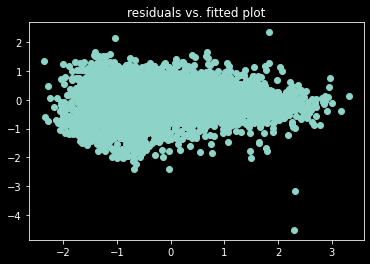

In [12]:
plt.scatter(slm.predy, slm.u)
plt.title("residuals vs. fitted plot")
plt.show()

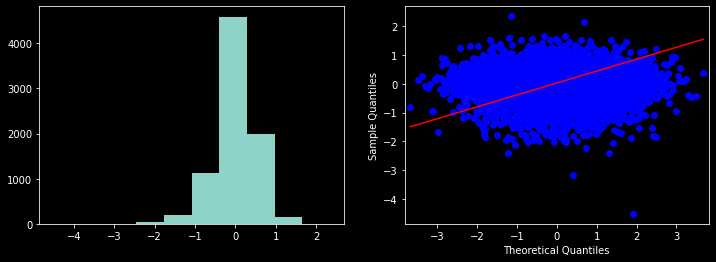

In [11]:
q_q_plot(slm.u)

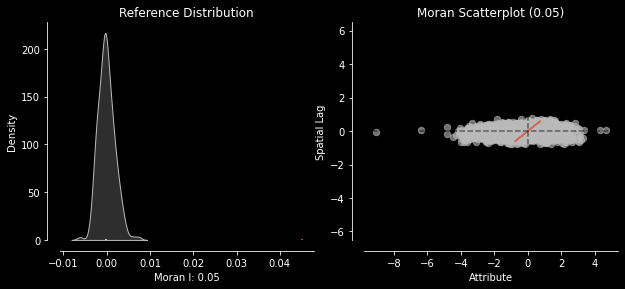

In [13]:
slm_moran = Moran(slm.u, w, permutations=199)
plot_moran(slm_moran, zstandard=True, figsize=(10,4))
plt.show()

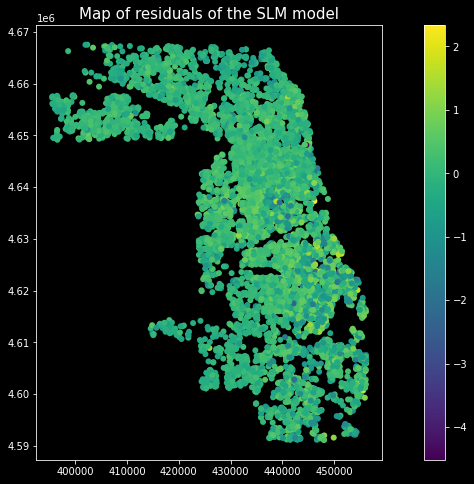

In [14]:
ax = gdf.plot(column=slm.u.reshape(-1),legend=True,figsize=(15,8), linewidth=0.0)
plt.title("Map of residuals of the SLM model",fontsize=15)
plt.show()